In [3]:
import numpy as np
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import cv2
import os

In [4]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 775.8 kB/s eta 0:00:000:00:01


In [6]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
#from gradcam import VizGradCAM
# from keras import backend as K
import tensorflow.keras.backend as K
# import tensorflow.keras.layers as L
from keras.models import Sequential, load_model, Model
# https://stackoverflow.com/questions/58047454/how-to-fix-module-keras-backend-tensorflow-backend-has-no-attribute-is-tf

*  ChestX-ray8 dataset which contains 108,948 frontal-view X-ray images of 32,717 unique patients
* diagnose 8 different diseases.
* multilabel classification

In [7]:
# path of the files
DIR = '/kaggle/input/chestxray8-dataframe/train_df.csv'

In [8]:
df = pd.read_csv(DIR)
df.head()

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


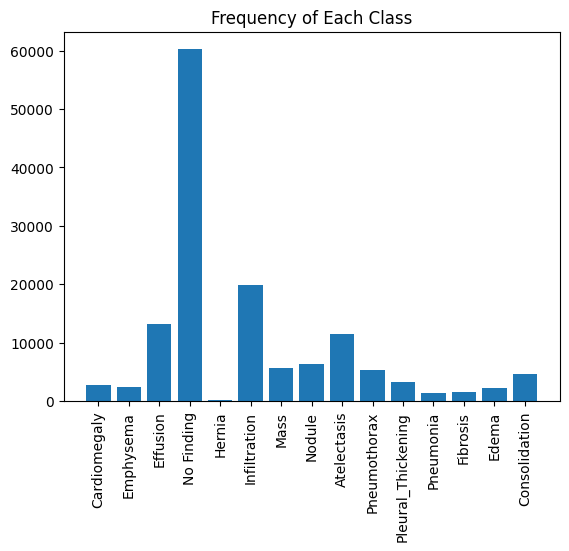

In [9]:
plt.xticks(rotation=90)
plt.bar(x = df.columns[2:-1], height=np.sum(df.iloc[:,2:-1], axis=0))
plt.title("Frequency of Each Class")
plt.show()

We must drop 'No finding' as it is not useful in our case

In [10]:
df.drop(['No Finding'], axis = 1, inplace = True)

In [11]:
df.shape

(111863, 17)

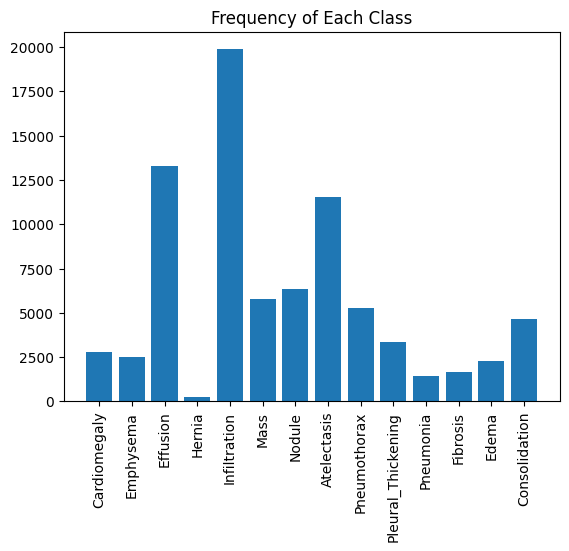

In [12]:
plt.xticks(rotation=90)
plt.bar(x = df.columns[2:-1], height=np.sum(df.iloc[:,2:-1], axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [13]:
def plotimg(path):
    img = plt.imread(path)
    plt.imshow(img, cmap = 'gray')
    print('Shape of image - ',np.array(img).shape)
    plt.show()

def plotimgcv(img):
    plt.imshow(img)
    print('Shape of image - ',np.array(img).shape)
    plt.show()

Shape of image -  (1024, 1024)


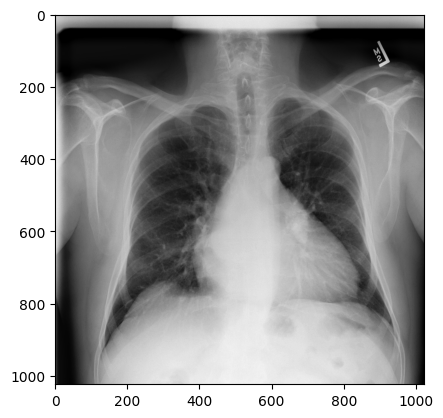

Class - Image Index                                           00000001_001.png
Patient ID                                                           1
Cardiomegaly                                                         1
Emphysema                                                            1
Effusion                                                             0
Hernia                                                               0
Infiltration                                                         0
Mass                                                                 0
Nodule                                                               0
Atelectasis                                                          0
Pneumothorax                                                         0
Pleural_Thickening                                                   0
Pneumonia                                                            0
Fibrosis                                                             

In [14]:
# viz original images
plotimg(df.loc[1, 'FilePath'])
print('Class -',df.loc[1])

Hence the patient has multiple lung infections, and the image is grayscale

In [15]:
# unsharp masking 
def umasking(img):
    test=img.copy()
    smooth = cv2.GaussianBlur(test, (0, 0), 2.0)
    unsharp = cv2.addWeighted(test, 2, smooth, -1, 0)
    return unsharp

# histogram equalization
def histequal(img):
    test=img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(test)
    return cl1

# https://stackoverflow.com/questions/12023958/what-does-cvnormalize-src-dst-0-255-norm-minmax-cv-8uc1
def preprocess(img):
    grayimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_n = cv2.normalize(src=grayimage, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    imgup = umasking(img_n)
    grayimg = histequal(imgup)
    rgbimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2RGB)
    return rgbimg

Shape of image -  (1024, 1024, 3)


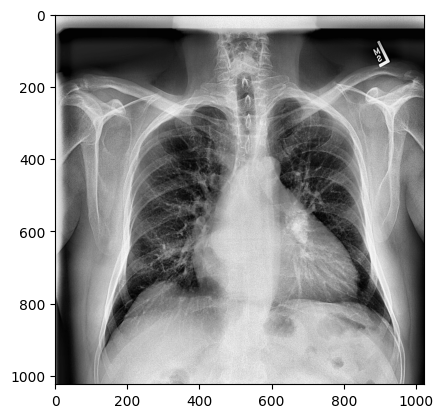

In [16]:
# test the preprocessing
img = cv2.imread(df.loc[1, 'FilePath'], cv2.IMREAD_GRAYSCALE)
imgup = umasking(img)
imgup1 = histequal(imgup)
bgrimg = cv2.cvtColor(imgup1, cv2.COLOR_GRAY2BGR)
plotimgcv(bgrimg)

In [17]:
# dataset parameters
CLASS_MODE = 'raw' # as the class labels have numeric probabilities
TARGET_SIZE = (224,224)
EPOCHS = 5 
BATCH_SIZE = 32 

In [18]:
# Record the labels
labels = df.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [19]:
# preprocessing on each image
def create_datagen():
    return ImageDataGenerator(preprocessing_function = preprocess)

In [20]:
def create_train_gen(datagen, traindata):
    return datagen.flow_from_dataframe(
        traindata, 
        x_col='FilePath', 
        y_col=labels,
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

In [21]:
def create_val_gen(datagen, val_data): 
    return datagen.flow_from_dataframe(
        val_data, 
        x_col='FilePath', 
        y_col=labels,
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [22]:
# test
def create_test_gen(datagen, testdata): 
    return datagen.flow_from_dataframe(
        testdata, 
        x_col='FilePath', 
        y_col=labels,
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

Split data into train and validation sets

In [23]:
from sklearn.model_selection import train_test_split

trainvalsplit, testsplit = train_test_split(df, test_size=0.2, random_state=42)
trainsplit, valsplit = train_test_split(trainvalsplit, test_size=0.2, random_state=42)

In [24]:
print(trainsplit.shape, valsplit.shape, testsplit.shape)

(71592, 17) (17898, 17) (22373, 17)


In [25]:
# preprocessed images = Takes 6 mins to run
data_generator = create_datagen()
train_gen = create_train_gen(data_generator, trainsplit)
val_gen = create_val_gen(data_generator, valsplit)
test_gen = create_test_gen(data_generator, testsplit)

Found 71592 validated image filenames.
Found 17898 validated image filenames.
Found 22373 validated image filenames.


Plot the preprocessed images

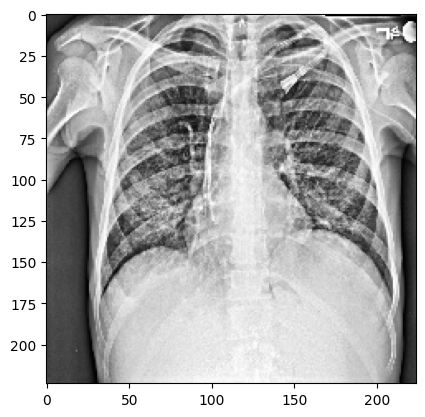

In [26]:
x, y = val_gen.__getitem__(0)
plt.imshow(x[2]/255)
# https://stackoverflow.com/questions/70284922/image-data-generator-not-producing-image-after-giving-preprocessing-function-arg

Address Class imbalance using freq weighted loss

In [27]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    N = labels.shape[0]
    
    n_class = labels.shape[1]
    
    positive_frequencies = np.sum(labels==1,axis=0)/N
    negative_frequencies = np.sum(labels==0,axis=0)/N

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [28]:
freq_pos, freq_neg = compute_class_freqs(train_gen.labels)
#labels = newtrain_df.columns[3:]
#freq_pos, freq_neg = compute_class_freqs(newtrain_df.iloc[:,3:])
freq_pos

array([0.02456978, 0.0219857 , 0.11907755, 0.0020114 , 0.1777992 ,
       0.05124874, 0.05609565, 0.10258129, 0.04693262, 0.030157  ,
       0.01262711, 0.01511342, 0.02049112, 0.04140127])

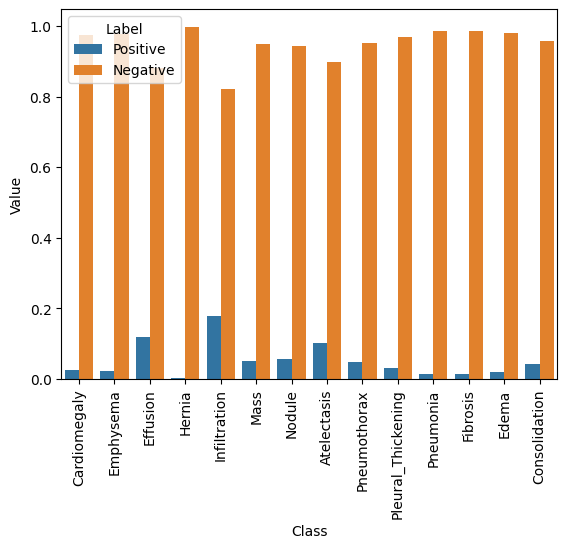

In [29]:
data = pd.DataFrame({"Class": trainsplit.columns[2:-1], "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame({"Class": trainsplit.columns[2:-1][l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg))], ignore_index=True)
# https://stackoverflow.com/questions/75956209/error-dataframe-object-has-no-attribute-append
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [30]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

<Axes: xlabel='Class', ylabel='Value'>

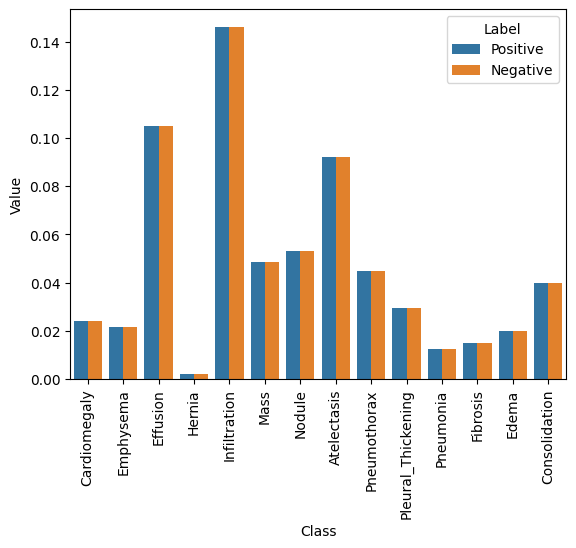

In [31]:
data = pd.DataFrame({"Class": trainsplit.columns[2:-1], "Label": "Positive", "Value": pos_contribution})
data = pd.concat([data, pd.DataFrame({"Class": trainsplit.columns[2:-1][l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution))], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [32]:
import keras 
import tensorflow.keras.backend as K
# from keras import backend as K ## gives error

# weighted loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    
    
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        y_true = tf.cast(y_true, tf.float32)
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1*K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon))
            loss_neg = -1*K.mean(neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))
            loss += loss_pos + loss_neg #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [33]:
def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

Model creation

1. Mobilenet

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# how we define a MobileNet model
def build_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model = build_model()
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

# training
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_gen) // BATCH_SIZE,
    epochs=30,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

Epoch 1/30
 1/69 ━━━━━━━━━━━━━━━━━━━━ 19:55 18s/step - accuracy: 0.0000e+00 - loss: 1.1199

W0000 00:00:1714639479.602570     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.0708 - loss: 1.0845

W0000 00:00:1714639541.912656     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.0711 - loss: 1.0836 - val_accuracy: 0.0515 - val_loss: 0.9299
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0970 - loss: 0.9637 - val_accuracy: 0.1342 - val_loss: 0.9069
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 67s 991ms/step - accuracy: 0.1220 - loss: 0.9382 - val_accuracy: 0.0478 - val_loss: 0.9050
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 926ms/step - accuracy: 0.0789 - loss: 0.8899 - val_accuracy: 0.1085 - val_loss: 0.8878
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 896ms/step - accuracy: 0.0977 - loss: 0.8805 - val_accuracy: 0.0754 - val_loss: 0.8960
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 898ms/step - accuracy: 0.0761 - loss: 0.8882 - val_accuracy: 0.0570 - val_loss: 0.9037
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 894ms/step - accuracy: 0.0634 - loss: 0.8925 - val_accuracy: 0.0607 - val_loss: 0.8832
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 900ms/step - accuracy: 0.0592 - loss: 0.9060 - val_accuracy: 0.0386 - va

W0000 00:00:1714640540.521101     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 909ms/step - accuracy: 0.0492 - loss: 0.8644 - val_accuracy: 0.0386 - val_loss: 0.8731
Epoch 18/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 926ms/step - accuracy: 0.0423 - loss: 0.8657 - val_accuracy: 0.0404 - val_loss: 0.8279
Epoch 19/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 911ms/step - accuracy: 0.0555 - loss: 0.8988 - val_accuracy: 0.0331 - val_loss: 0.8996
Epoch 20/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 910ms/step - accuracy: 0.0423 - loss: 0.9012 - val_accuracy: 0.0404 - val_loss: 0.8713
Epoch 21/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 916ms/step - accuracy: 0.0421 - loss: 0.8860 - val_accuracy: 0.0570 - val_loss: 0.8906
Epoch 22/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 948ms/step - accuracy: 0.0613 - loss: 0.8838 - val_accuracy: 0.0404 - val_loss: 0.8591
Epoch 23/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 64s 942ms/step - accuracy: 0.0515 - loss: 0.8739 - val_accuracy: 0.0423 - val_loss: 0.8630
Epoch 24/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 930ms/step - accuracy: 0.0443 - loss: 0.8809 - val_accuracy

  1/700 ━━━━━━━━━━━━━━━━━━━━ 32:49 3s/step

W0000 00:00:1714641515.419839     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 596s 848ms/step


W0000 00:00:1714642108.486294     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 597s 854ms/step - accuracy: 0.0473 - loss: 0.8632


W0000 00:00:1714642708.353459     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.8625088930130005
Test Accuracy: 0.047870200127363205
Precision: 0.1440453450306989
Recall: 0.6339055793991416
F1-Score: 0.21976491179899016
ROC AUC Score: 0.6218753514011245
Mean ROC AUC Score: 0.6218753514011245


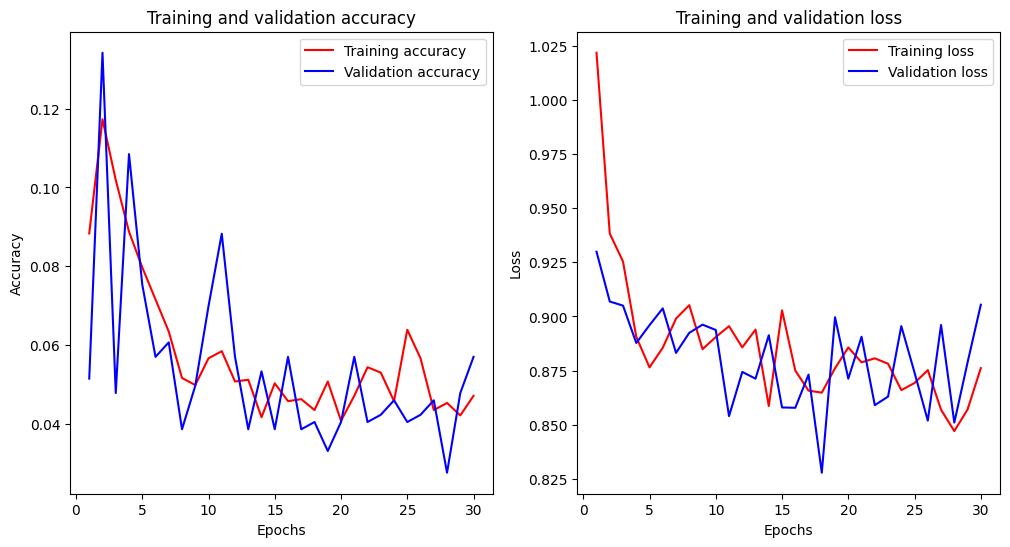

In [84]:
# evaluate the model on the test set
y_true = test_gen.labels
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round(), average='weighted')
recall = recall_score(y_true, y_pred.round(), average='weighted')
f1 = f1_score(y_true, y_pred.round(), average='weighted')
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Mean ROC AUC Score:", roc_auc.mean())

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2. VGG

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# how we define a VGG model
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model = build_model()
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

# training
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_gen) // BATCH_SIZE,
    epochs=30,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

Epoch 1/30
 1/69 ━━━━━━━━━━━━━━━━━━━━ 16:31 15s/step - accuracy: 0.0625 - loss: 3.5692

W0000 00:00:1714636086.669333     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.0538 - loss: 3.0877

W0000 00:00:1714636148.131089     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.0538 - loss: 3.0813 - val_accuracy: 0.0827 - val_loss: 1.4781
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 997ms/step - accuracy: 0.0822 - loss: 1.7740 - val_accuracy: 0.0993 - val_loss: 1.2215
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 950ms/step - accuracy: 0.0812 - loss: 1.2465 - val_accuracy: 0.0956 - val_loss: 1.0420
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 914ms/step - accuracy: 0.0898 - loss: 1.0472 - val_accuracy: 0.0882 - val_loss: 0.9399
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 918ms/step - accuracy: 0.0803 - loss: 0.9663 - val_accuracy: 0.0643 - val_loss: 0.9531
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 972ms/step - accuracy: 0.0693 - loss: 0.9228 - val_accuracy: 0.0790 - val_loss: 0.9323
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 907ms/step - accuracy: 0.0350 - loss: 0.9163 - val_accuracy: 0.0478 - val_loss: 0.9075
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 871ms/step - accuracy: 0.0427 - loss: 0.9147 - val_accuracy: 0.0827 -

  2/700 ━━━━━━━━━━━━━━━━━━━━ 1:40 144ms/step

W0000 00:00:1714637987.998391     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 593s 844ms/step
700/700 ━━━━━━━━━━━━━━━━━━━━ 596s 852ms/step - accuracy: 0.2075 - loss: 0.8943
Test Loss: 0.8934140205383301
Test Accuracy: 0.20891252160072327
Precision: 0.12163140820523848
Recall: 0.5162477007970571
F1-Score: 0.18535262956015305
ROC AUC Score: 0.5679540849025335
Mean ROC AUC Score: 0.5679540849025335


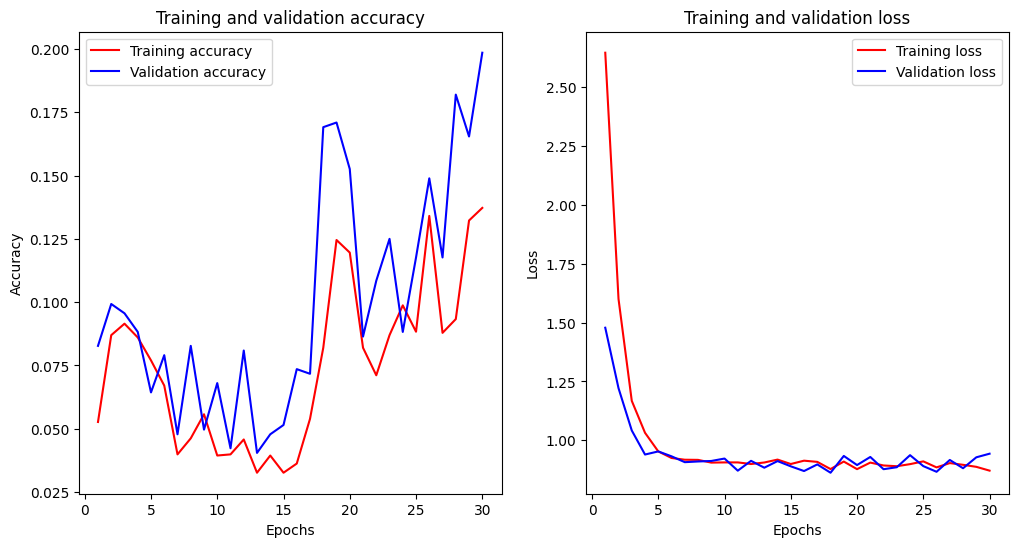

In [82]:
# evaluate the model on the test set
y_true = test_gen.labels
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round(), average='weighted')
recall = recall_score(y_true, y_pred.round(), average='weighted')
f1 = f1_score(y_true, y_pred.round(), average='weighted')
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Mean ROC AUC Score:", roc_auc.mean())

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3. Resnet50

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# how we define a ResNet model
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model = build_model()
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

# training
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_gen) // BATCH_SIZE,
    epochs=30,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

Epoch 1/30
 2/69 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.2891 - loss: 0.9889  

W0000 00:00:1714631945.205839     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.1649 - loss: 1.0063

W0000 00:00:1714632010.764941     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1640 - loss: 1.0059 - val_accuracy: 0.0533 - val_loss: 0.9219
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0767 - loss: 0.9317 - val_accuracy: 0.0717 - val_loss: 0.9031
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 998ms/step - accuracy: 0.0531 - loss: 0.9112 - val_accuracy: 0.0257 - val_loss: 0.8962
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 920ms/step - accuracy: 0.0986 - loss: 0.9056 - val_accuracy: 0.1195 - val_loss: 0.8831
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 863ms/step - accuracy: 0.1433 - loss: 0.8753 - val_accuracy: 0.1287 - val_loss: 0.8957
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 873ms/step - accuracy: 0.2010 - loss: 0.8994 - val_accuracy: 0.1985 - val_loss: 0.8926
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 889ms/step - accuracy: 0.1542 - loss: 0.8378 - val_accuracy: 0.2537 - val_loss: 0.8653
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 861ms/step - accuracy: 0.1688 - loss: 0.9156 - val_accuracy: 0.1103 - v

W0000 00:00:1714632786.358683     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 870ms/step - accuracy: 0.2478 - loss: 0.8710 - val_accuracy: 0.2298 - val_loss: 0.8594
Epoch 15/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 910ms/step - accuracy: 0.1850 - loss: 0.8728 - val_accuracy: 0.3051 - val_loss: 0.8246
Epoch 16/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 891ms/step - accuracy: 0.2087 - loss: 0.8637 - val_accuracy: 0.2169 - val_loss: 0.8341
Epoch 17/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 882ms/step - accuracy: 0.1733 - loss: 0.8724 - val_accuracy: 0.2665 - val_loss: 0.8401
Epoch 18/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 916ms/step - accuracy: 0.2096 - loss: 0.8691 - val_accuracy: 0.2298 - val_loss: 0.7985
Epoch 19/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 871ms/step - accuracy: 0.1611 - loss: 0.8420 - val_accuracy: 0.2757 - val_loss: 0.8694
Epoch 20/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 869ms/step - accuracy: 0.1576 - loss: 0.8079 - val_accuracy: 0.1232 - val_loss: 0.8256
Epoch 21/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 868ms/step - accuracy: 0.1434 - loss: 0.8629 - val_accuracy

700/700 ━━━━━━━━━━━━━━━━━━━━ 593s 848ms/step


W0000 00:00:1714635044.351215     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 535s 765ms/step - accuracy: 0.1444 - loss: 0.8317


W0000 00:00:1714635581.310735     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.8292121887207031
Test Accuracy: 0.14602422714233398
Precision: 0.1541590872384377
Recall: 0.6576333537706929
F1-Score: 0.23861556337514253
ROC AUC Score: 0.6784366321060276
Mean ROC AUC Score: 0.6784366321060276


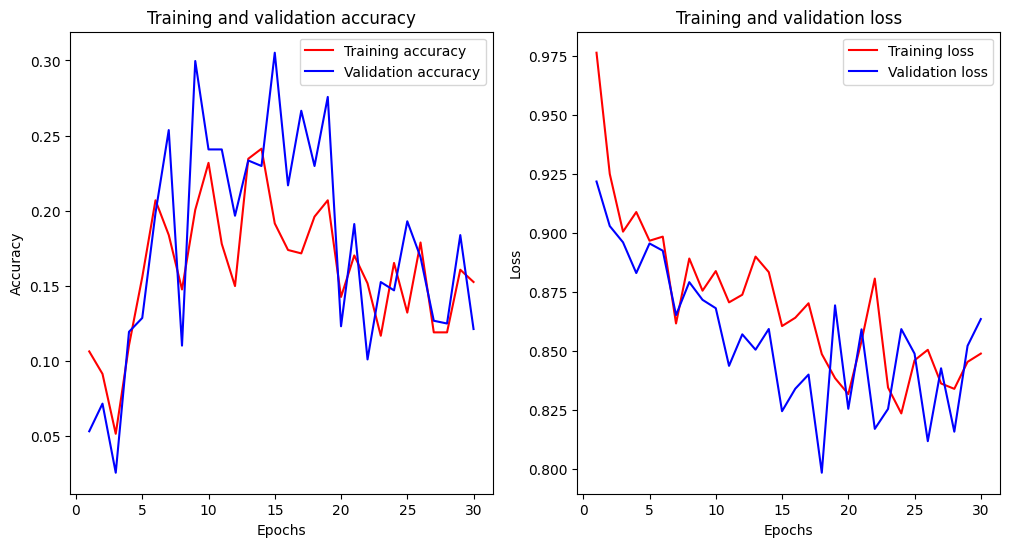

In [79]:
# evaluate the model on the test set
y_true = test_gen.labels
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round(), average='weighted')
recall = recall_score(y_true, y_pred.round(), average='weighted')
f1 = f1_score(y_true, y_pred.round(), average='weighted')
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Mean ROC AUC Score:", roc_auc.mean())

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

4. Densenet

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# how we define a DenseNet model
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model = build_model()
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

# training
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_gen) // BATCH_SIZE,
    epochs=30,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
 2/69 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.1562 - loss: 1.8377 

W0000 00:00:1714628447.550819     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.0841 - loss: 1.5927

W0000 00:00:1714628518.573066     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.0839 - loss: 1.5898 - val_accuracy: 0.0790 - val_loss: 0.9947
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.0701 - loss: 1.0584 - val_accuracy: 0.0662 - val_loss: 0.9333
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0764 - loss: 0.9407 - val_accuracy: 0.0717 - val_loss: 0.9154
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 910ms/step - accuracy: 0.0653 - loss: 0.8753 - val_accuracy: 0.0441 - val_loss: 0.8977
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 867ms/step - accuracy: 0.0494 - loss: 0.9121 - val_accuracy: 0.0607 - val_loss: 0.9104
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 871ms/step - accuracy: 0.0320 - loss: 0.9327 - val_accuracy: 0.0276 - val_loss: 0.9141
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 896ms/step - accuracy: 0.0386 - loss: 0.9119 - val_accuracy: 0.0496 - val_loss: 0.8931
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 58s 855ms/step - accuracy: 0.0431 - loss: 0.9073 - val_accuracy: 0.0257 - val_

W0000 00:00:1714629897.985765     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 997ms/step - accuracy: 0.0288 - loss: 0.9046 - val_accuracy: 0.0423 - val_loss: 0.9379
Epoch 25/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 58s 853ms/step - accuracy: 0.0453 - loss: 0.8824 - val_accuracy: 0.0588 - val_loss: 0.9021
Epoch 26/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 889ms/step - accuracy: 0.0436 - loss: 0.9079 - val_accuracy: 0.0423 - val_loss: 0.8716
Epoch 27/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 874ms/step - accuracy: 0.0358 - loss: 0.9110 - val_accuracy: 0.0460 - val_loss: 0.9262
Epoch 28/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 875ms/step - accuracy: 0.0360 - loss: 0.9264 - val_accuracy: 0.0404 - val_loss: 0.8940
Epoch 29/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 905ms/step - accuracy: 0.0502 - loss: 0.8954 - val_accuracy: 0.0607 - val_loss: 0.9333
Epoch 30/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 58s 850ms/step - accuracy: 0.0341 - loss: 0.8988 - val_accuracy: 0.0551 - val_loss: 0.9366


  2/700 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step   

W0000 00:00:1714630404.504341     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 571s 799ms/step


W0000 00:00:1714630963.290994     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 587s 839ms/step - accuracy: 0.0512 - loss: 0.9017


W0000 00:00:1714631551.917241     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.9003322124481201
Test Accuracy: 0.05189290642738342
Precision: 0.12284780419211264
Recall: 0.524892703862661
F1-Score: 0.1826396886030179
ROC AUC Score: 0.558565508357109
Mean ROC AUC Score: 0.558565508357109


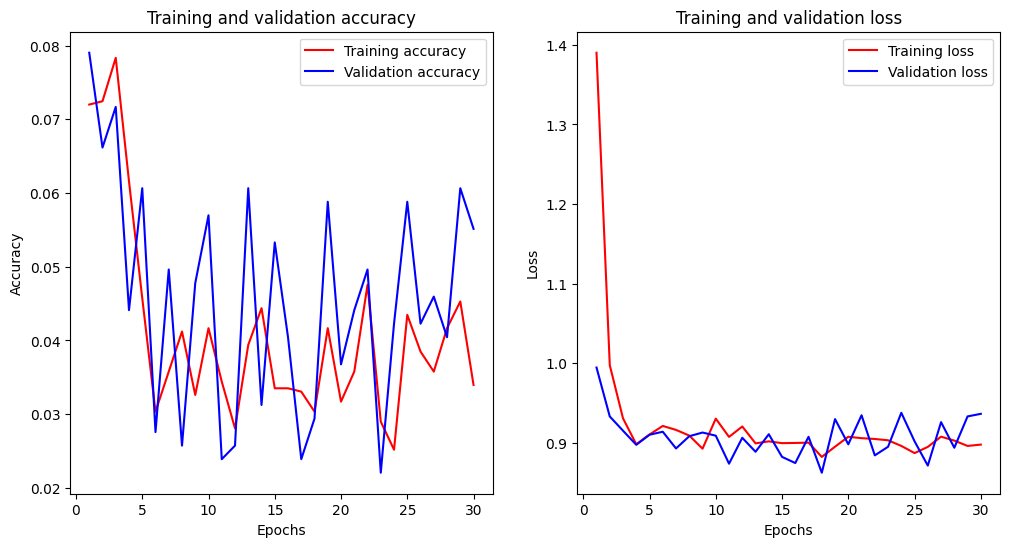

In [75]:
# evaluate the model on the test set
y_true = test_gen.labels
y_pred = model.predict(test_gen)

# calculate and print metrics
loss, accuracy = model.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round(), average='weighted')
recall = recall_score(y_true, y_pred.round(), average='weighted')
f1 = f1_score(y_true, y_pred.round(), average='weighted')
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Mean ROC AUC Score:", roc_auc.mean())

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

5. Efficient Net:

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import EfficientNetB0
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


# how we define an EfficientNet model
def build_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

modelE = build_model()
modelE.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])


# training
history = modelE.fit(
    train_gen,
    steps_per_epoch=len(train_gen) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_gen) // BATCH_SIZE,
    epochs=30,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)
# split-------------------------------

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
 2/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.0547 - loss: 0.9364  

I0000 00:00:1714686198.996571     156 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714686199.060494     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.0395 - loss: 0.9212

W0000 00:00:1714686269.372440     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.0395 - loss: 0.9210 - val_accuracy: 0.0312 - val_loss: 0.9121
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0522 - loss: 0.8787 - val_accuracy: 0.0551 - val_loss: 0.8958
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 994ms/step - accuracy: 0.0762 - loss: 0.8969 - val_accuracy: 0.0625 - val_loss: 0.8960
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 911ms/step - accuracy: 0.0927 - loss: 0.9131 - val_accuracy: 0.1379 - val_loss: 0.8734
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 52s 758ms/step - accuracy: 0.1067 - loss: 0.8667 - val_accuracy: 0.1765 - val_loss: 0.8921
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 867ms/step - accuracy: 0.1416 - loss: 0.8350 - val_accuracy: 0.2151 - val_loss: 0.8806
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 58s 854ms/step - accuracy: 0.1237 - loss: 0.9045 - val_accuracy: 0.1342 - val_loss: 0.8580
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 57s 839ms/step - accuracy: 0.1165 - loss: 0.8777 - val_accuracy: 0.1379 - v

W0000 00:00:1714687678.072883     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1143 - loss: 0.8509 - val_accuracy: 0.1232 - val_loss: 0.8076
Epoch 27/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 55s 804ms/step - accuracy: 0.0821 - loss: 0.8646 - val_accuracy: 0.0956 - val_loss: 0.8604
Epoch 28/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 54s 791ms/step - accuracy: 0.0798 - loss: 0.8507 - val_accuracy: 0.0974 - val_loss: 0.8202
Epoch 29/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 768ms/step - accuracy: 0.0857 - loss: 0.8921 - val_accuracy: 0.1434 - val_loss: 0.8608
Epoch 30/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 53s 770ms/step - accuracy: 0.1189 - loss: 0.8538 - val_accuracy: 0.1048 - val_loss: 0.8784


  1/700 ━━━━━━━━━━━━━━━━━━━━ 1:20:00 7s/step

W0000 00:00:1714688007.136448     156 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step


W0000 00:00:1714688784.962826     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


700/700 ━━━━━━━━━━━━━━━━━━━━ 394s 562ms/step - accuracy: 0.1050 - loss: 0.8358


W0000 00:00:1714689180.203944     155 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.8355004191398621
Test Accuracy: 0.10476914048194885
Precision: 0.14638454201677098
Recall: 0.6746167995095034
F1-Score: 0.2311531978512327
ROC AUC Score: 0.6964995363659735
Mean ROC AUC Score: 0.6964995363659735


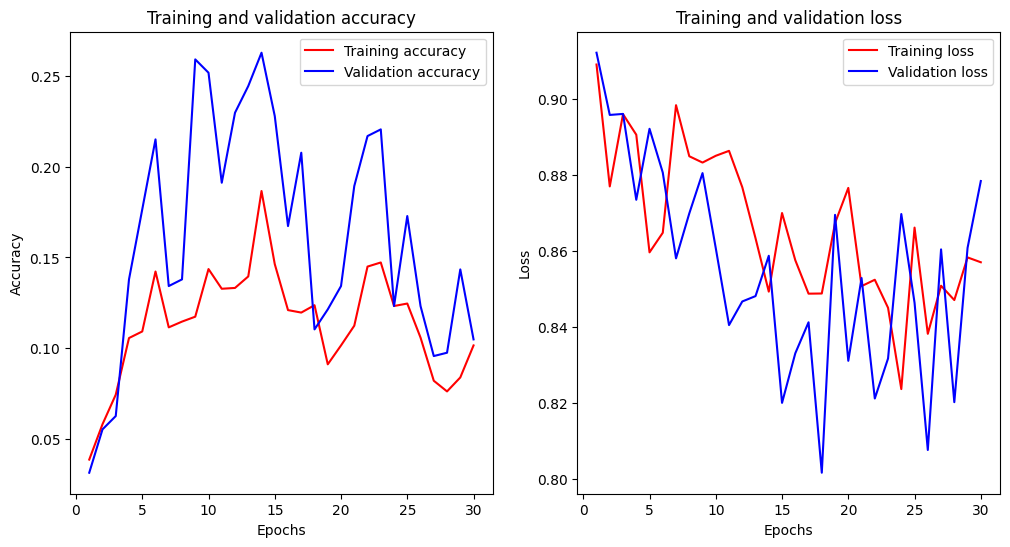

In [36]:
# evaluate the model on the test set
y_trueE = test_gen.labels
y_predE = modelE.predict(test_gen)

# calculate and print metrics
loss, accuracy = modelE.evaluate(test_gen)
precision = precision_score(y_trueE, y_predE.round(), average='weighted')
recall = recall_score(y_trueE, y_predE.round(), average='weighted')
f1 = f1_score(y_trueE, y_predE.round(), average='weighted')
roc_auc = roc_auc_score(y_trueE, y_predE)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Mean ROC AUC Score:", roc_auc.mean())

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

5. Vision Transformer

In [50]:
!pip install vit-keras
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.2 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from vit_keras import vit, utils

ROC CURVES

In [ ]:
# pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)
# test_Y = 

In [ ]:
# this plot code is from source = https://www.kaggle.com/code/kmader/train-simple-xray-cnn#Continued-Training
from sklearn.metrics import roc_curve, auc

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

GradCAM

In [39]:
def gradcam(lastconvlayer,img,gt,model,CLASS_INDEX=None):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(lastconvlayer).output, model.output])
    io_img = np.expand_dims(img, axis=0)
    print('Image shape -',io_img.shape)

    ###--Compute GRADIENT
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(io_img)
    ##--   Below is for multiclass
        if CLASS_INDEX is None:
            CLASS_INDEX = tf.math.round(predictions[0][0])
        class_channel = predictions[0]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(class_channel, conv_outputs)
    print('Gradients shape', grads.shape)
    print('Prediction', predictions)
    print('Ground truth', gt)
    
    # spatially average
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    # matmul the gradients with the convolution outputs
    heatmap = output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [40]:
# Below visualization code is from source = https://keras.io/examples/vision/grad_cam/
from IPython.display import Image, display
import matplotlib
import keras

def save_and_display_gradcam(heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image[0][0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

1. For EfficientNet

In [ ]:
#y_true = test_gen.classes
#y_pred = model3.predict(test_gen)
# check which ones are incorrect preds
#[i for i, x in enumerate(y_true) if y_true[i]!=y_pred[i].round()]

In [ ]:
modelE.summary() 

Image shape - (1, 224, 224, 3)
Gradients shape (1, 7, 7, 1280)
Prediction tf.Tensor(
[[0.5042413  0.40062475 0.4735868  0.30583823 0.5198304  0.51239955
  0.47103035 0.48847258 0.4493807  0.5202915  0.5457856  0.50065106
  0.5903271  0.5267899 ]], shape=(1, 14), dtype=float32)
Ground truth [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


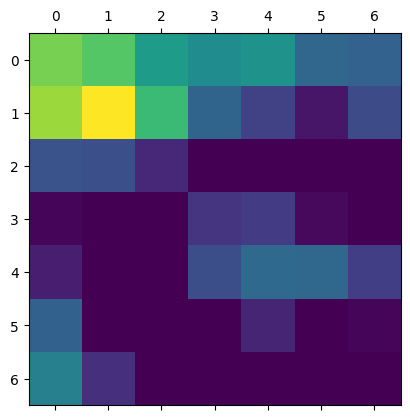

In [41]:
image = next(test_gen)
lastconvlayer = 'top_conv'

heatmap = gradcam(lastconvlayer, image[0][4], image[1][4], modelE)

plt.matshow(heatmap)
plt.show()

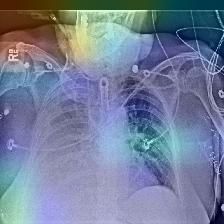

In [42]:
save_and_display_gradcam(heatmap)

2. For Mobilenet

In [ ]:
# y_true = test_gen.classes
# y_pred = model.predict(test_gen)
# check which ones are incorrect preds
# [i for i, x in enumerate(y_true) if y_true[i]!=y_pred[i].round()]

In [ ]:
# model.summary() 

In [ ]:
image = next(test_gen)
lastconvlayer = 'conv_pw_13'

heatmap = gradcam(lastconvlayer, image[0][4], image[1][4], model)

plt.matshow(heatmap)
plt.show()

In [ ]:
save_and_display_gradcam(heatmap)